Attempt to figure out the chips that are missing between the Healpix methods (mine) vs. lsst utils (Scotts).

The idea is to find all the pxiels that in the region 'border' (i.e. within a few pixels radius from the region edge) vs. in the main region (i.e., away from the border).

Getting numbers for DC1 with only 4 undithered FOVs allows a scaling for how many missing chips can be expected for DC2 with 30 FOVs.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import time
import pickle
import os
import healpy as hp
repoDir= os.getcwd()
os.chdir(os.path.join(repoDir , '..' ))
repoDir= os.getcwd()
import imageio
import matplotlib.patches as mpatches
from collections import OrderedDict
import pandas as pd
from intermediates import *
from readPython2Pickle import pickleRead # needed since working in Python 3.
from GIFproduction import * #obsMetaDataDict

In [2]:
from os.path import expanduser
home = expanduser("~")

In [3]:
from numpy.lib.recfunctions import append_fields

# read in simdata
datapath= home+'/lsstData/'

dbpath = datapath+'minion_1016_sqlite_new_dithers.db'   # new afterburner output
extraCols= ['expDate', 'obsHistID', 'ditheredRotTelPos', 'rotTelPos']
simdata= getSimData(dbpath, 'r', newAfterburner= True, extraCols= extraCols)

parallacticAngle= simdata['rotTelPos']-simdata['rotSkyPos'][:]
ditheredRotSkyPos= simdata['ditheredRotTelPos'][:]-parallacticAngle
simdata = append_fields(simdata, 'ditheredRotSkyPos', ditheredRotSkyPos,
                        dtypes= ditheredRotSkyPos.dtype, usemask=False, asrecarray=False)

In [4]:
wavefront= ['R:4,0 S:0,2,A', 'R:4,0 S:0,2,B','R:0,4 S:2,0,A', 'R:0,4 S:2,0,B',
           'R:0,0 S:2,2,A', 'R:0,0 S:2,2,B','R:4,4 S:0,0,A', 'R:4,4 S:0,0,B']

nonScience= ['R:0,0 S:1,2', 'R:0,0 S:2,1', 'R:0,4 S:1,0', 
             'R:0,4 S:2,1', 'R:4,0 S:0,1', 'R:4,0 S:1,2', 'R:4,4 S:0,1', 'R:4,4 S:1,0']

In [5]:
def pixNum2RaDec(nside, pix):
    theta, phi = hp.pix2ang(pix, nside)
    return phi, np.pi/2.0-theta 

In [6]:
def borderVsMainPlot(filenameToRead_mine, filenameToRead_scotts, nside, simdata, tag, 
                      transDithered, rotDithered):
    startTime= time.time()

    ignore, ignore, DC1Pixels= findRegionPixels(1447, simdata, nside= nside, disc= False, FOV_radius= 0.0305)
    DC1pixRA, DC1pixDec= pixNum2RaDec(DC1Pixels, nside)

    # set up a small dc1 region. 
    ignore, ignore, DC1Pixels_smaller= findRegionPixels(1447, simdata, nside= nside, 
                                                        disc= False, 
                                                        FOV_radius= 0.0305-(0.0305/15))  # smaller by chip side length
    DC1pixRA_smaller, DC1pixDec_smaller= pixNum2RaDec(DC1Pixels_smaller, nside)
    
    print(DC1pixRA, DC1pixDec)
    def withInBorder(xChipCenter, yChipCenter):
        # check if a given pixel is in the border: 
        # it is not if it is both in the DC1 region and the smaller-DC1 region.
        
        # find whether the center is in the DC1 region
        delRA= abs(DC1pixRA-xChipCenter)
        ind= np.where(delRA<0.001)[0]
        delDec= abs(DC1pixDec[ind]-yChipCenter)
        ind= np.where(delDec<0.001)[0]
        
        if (len(ind)==0): inDC1= False
        else: inDC1= True
            
        # find whether the center is in the smaller DC1 region
        delRA= abs(DC1pixRA_smaller-xChipCenter)
        ind= np.where(delRA<0.001)[0]
        delDec= abs(DC1pixDec_smaller[ind]-yChipCenter)
        ind= np.where(delDec<0.001)[0]
        
        if (len(ind)==0):
            inDC1small= False
        else:
            inDC1small= True
        
        if not inDC1:
            return True
        if inDC1 and inDC1small:
            return False
        if inDC1 and not inDC1small:        
            return True
        
    # read in the data
    savedData= OrderedDict()
    savedData['mine']= {}
    savedData['scotts']= {}

    with open(filenameToRead_mine, 'rb') as handle:
        savedData['mine']= pickleRead(handle)

    with open(filenameToRead_scotts, 'rb') as handle:
        savedData['scotts']= pickleRead(handle)
    
    # read in the meta data for all observations. needed to get chips edges for plotting.
    obsMetaData= {}
    for key in savedData.keys():
        obsMetaData[key]= obsMetaDataDict(savedData[key]['obsHistID'], simdata, transDithered, rotDithered)
    camera= LsstSimMapper().camera
    
    # plot helpers
    factor= .01
    xmin, xmax= 1.54, 1.72
    ymin, ymax= -0.56, -0.42
    kargs= {'fps': 1}
    
    fontsize= 14
    
    stepsize = np.pi/50.
    theta = np.arange(0, np.pi*2.+stepsize, stepsize)
    radius= 0.0305
    delx= radius*np.cos(theta)
    dely= radius*np.sin(theta)
    
    def getXYchips(chip, camera, obsData):
        x, y= np.zeros(5), np.zeros(5)
        [(x[0], y[0]), (x[1], y[1]), (x[3], y[3]), (x[2], y[2])]= getCornerRaDec(chip,  camera,  obsData)
        x[4], y[4]= x[0], y[0]        
        x, y= np.deg2rad(x), np.deg2rad(y)
        return x,y
    
    def getChipCenter(chip, camera, obsData):
        x, y= np.zeros(4), np.zeros(4)
        [(x[0], y[0]), (x[1], y[1]), (x[3], y[3]), (x[2], y[2])]= getCornerRaDec(chip, camera, obsData)
        x, y= np.deg2rad(x), np.deg2rad(y)
        xmin= x[0]
        ymin= y[0]
        ymax= y[1]
        xmax= x[2]
        return xmin+(xmax-xmin)/2., ymin+(ymax-ymin)/2.
    
    # fID plots
    for fid in np.array([1447]): #np.array([1447, 1464, 1323, 1220]): #np.unique(savedData[key]['fIDs']):
        centralRA, centralDec, regionPixels= findFOVPixels(fid, simdata, nside= nside,
                                                           FOV_radius= 0.0305)
        # find some objHistIDs to plot.
        key0= list(savedData.keys())[0]
        inds= np.where(savedData[key0]['fIDs']==fid)[0]
        hID_ofInterest= np.array(savedData[key0]['obsHistID'])[inds]
        key1= list(savedData.keys())[1]

        for hth, hid in enumerate(np.sort(np.unique(hID_ofInterest)[2:10])): # run over only a few hIDs for illustration
            fig, allax= plt.subplots(1,2)
            for kInd, key in enumerate(savedData.keys()):

                axes= allax[kInd]
                axes.plot(DC1pixRA, DC1pixDec, 'o', color= 'g', alpha= 0.01)
                pixRA, pixDec= pixNum2RaDec(regionPixels, nside)
                axes.plot(pixRA, pixDec, '.', color= 'k', alpha= 0.01)
                inds= np.where(savedData[key]['obsHistID']==hid)[0]

                color= None
                if (len(inds)>0):  # need to make sure histID is in the list.
                    if (len(inds)>1): 
                        print('PROBLEM: more than one entry for a histID.'); 
                        return
                    else:
                        inds= inds[0]

                    # plot chips
                    for chip in savedData[key]['chipNames'][inds]:        
                        x, y= getXYchips(chip, camera, obsMetaData[key][hid])
                        pointingRA, pointingDec= np.radians(obsMetaData[key][hid].pointingRA), np.radians(obsMetaData[key][hid].pointingDec)
                        axes.plot(pointingRA, pointingDec, 'x', color= 'k')
                        axes.plot(pointingRA+delx/np.cos(pointingDec), pointingDec+dely, color= 'k', label= 'FOV')
                        axes.fill(x,y, 'b', alpha=0.2, edgecolor='r')

                    # set up colors
                    if (kInd==0):
                        otherKey= key1
                        color= 'm'
                    elif (kInd==1):
                        otherKey= key0
                        color= 'k'
                    else:
                        color= None

                    # check missing
                    inds2= np.array(np.where(savedData[otherKey]['obsHistID']==hid)[0])
                    if (len(inds2)>1):
                        print('PROBLEM: more than one entry for a histID.'); 
                    elif (len(inds2)>0):
                        inds2= inds2[0]
                        current= set(savedData[key]['chipNames'][inds]) - set(nonScience)
                        other= set(savedData[otherKey]['chipNames'][inds2]) - set(nonScience)
                        missing= other-current
                    else:
                        missing= []

                    # figure out border vs. main
                    inBorder= 0
                    inMain= 0
                    for chip in missing:
                        x, y= getXYchips(chip, camera, obsMetaData[key][hid])
                        axes.plot(x,y, color, label= 'Missing here; present in the other.')

                        xChipCenter, yChipCenter= getChipCenter(chip, camera, obsMetaData[key][hid])
                        if withInBorder(xChipCenter, yChipCenter):
                            inBorder+=1
                        else:
                            inMain+=1

                    # plot wavefront
                    for chip in wavefront:
                        x, y= getXYchips(chip, camera,obsMetaData[key][hid])
                        axes.fill(x,y, 'c', alpha=1., edgecolor='c')

                    # plot guiders
                    for chip in nonScience:
                        x, y= getXYchips(chip, camera,obsMetaData[key][hid])
                        axes.fill(x,y, 'y', alpha=1., edgecolor='y')

                axes.set_xlabel('RA', fontsize= fontsize)
                axes.set_ylabel('Dec', fontsize= fontsize)
                axes.tick_params(axis='x', labelsize=fontsize)
                axes.tick_params(axis='y', labelsize=fontsize)

                axes.set_title('%s\nhID: %s ; fid: %s; Missing inBorder: %s, Missing in Main: %s '%(key, hid ,fid, inBorder, inMain), fontsize= fontsize)

                blue = mpatches.Patch(color='blue', edgecolor= 'red', label= 'DC1 Chips', alpha= 0.2)
                yellow = mpatches.Patch(color='y' , label= 'non-science')
                cyan = mpatches.Patch(color='c', label= 'wavefront')

                if color is not None:
                    missing = mpatches.Patch(color= color, fill= False,  label= 'Missing here; present in the other.')

                handles, labels = axes.get_legend_handles_labels()
                if color is not None:
                    axes.legend(handles= [blue, yellow, cyan, missing], bbox_to_anchor= (1.,-0.1))
                else:
                    axes.legend(handles= [blue, yellow, cyan], bbox_to_anchor= (1.,-0.1))
                axes.set_xlim([xmin-factor, xmax+factor]) 
                axes.set_ylim([ymin-factor, ymax+factor])    

            fig.set_size_inches(16,8)
            plt.show()

[ 1.63522352  1.6367575   1.63829148 ...,  1.62678663  1.62832061
  1.62985459] [-0.43910574 -0.43910574 -0.43910574 ..., -0.55393948 -0.55393948
 -0.55393948]


Exception ignored in: <bound method SqlRegistry.__del__ of <lsst.daf.persistence.registries.SqliteRegistry object at 0x15298a390>>
Traceback (most recent call last):
  File "/Users/humnaawan/lsst/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/daf_persistence/u.danielsf.2.3.7.1.sims-g674f0d60ff/python/lsst/daf/persistence/registries.py", line 320, in __del__
    super(SqlRegistry, self).__del__()
AttributeError: 'super' object has no attribute '__del__'
/Users/humnaawan/lsst/python/miniconda3-4.3.21/lib/python3.6/site-packages/matplotlib/patches.py:121: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


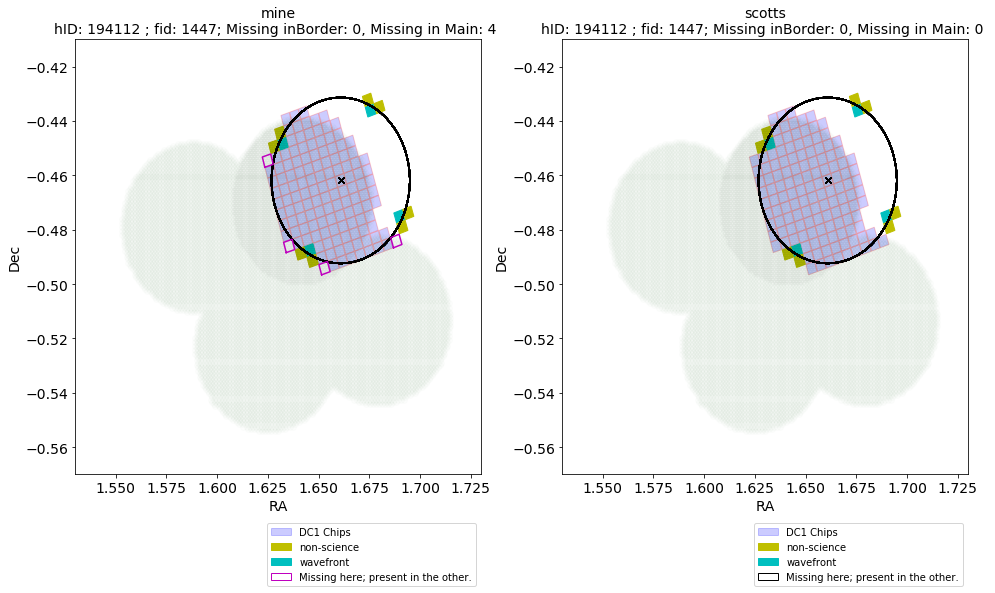

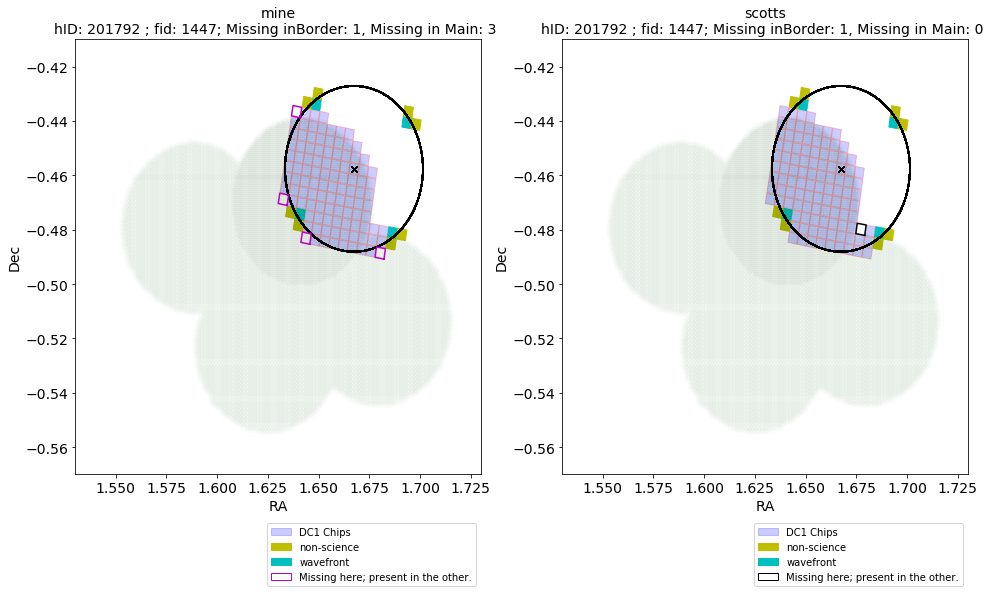

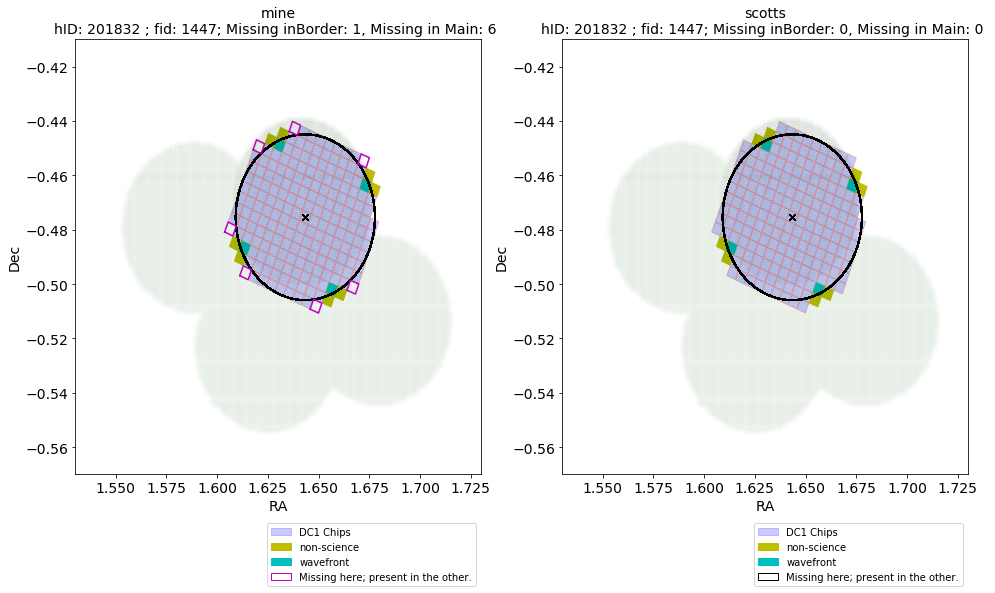

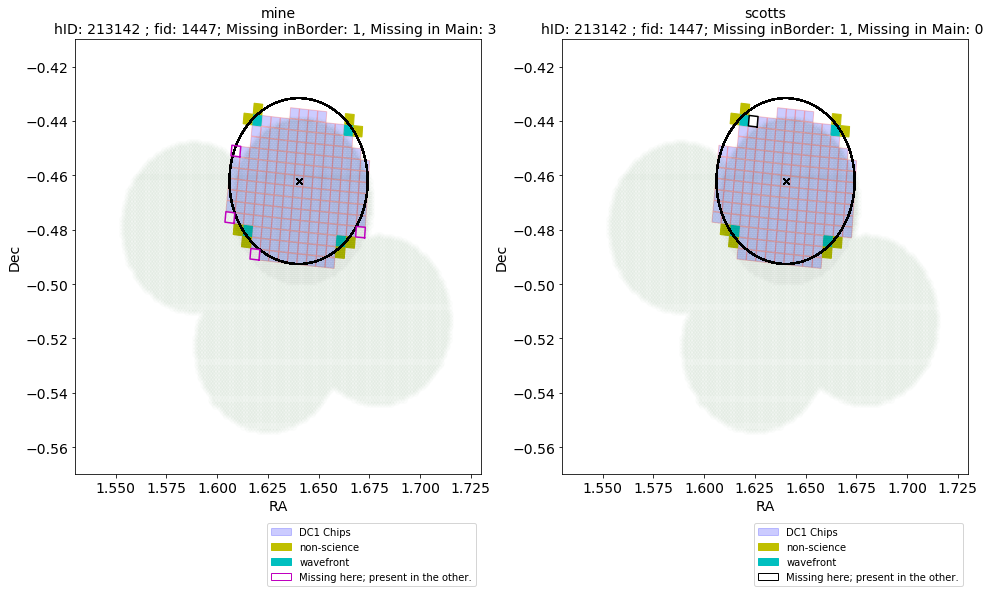

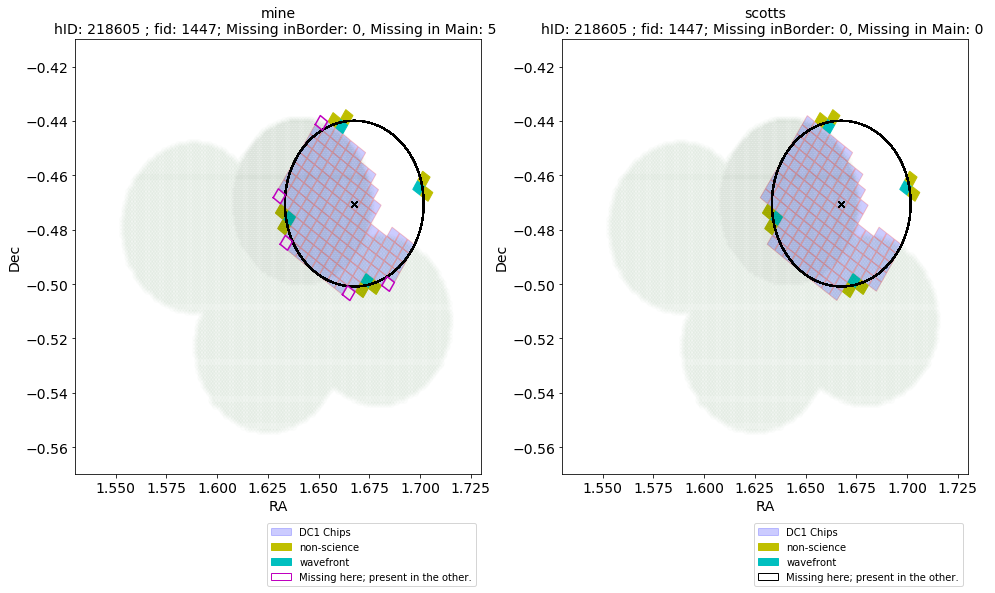

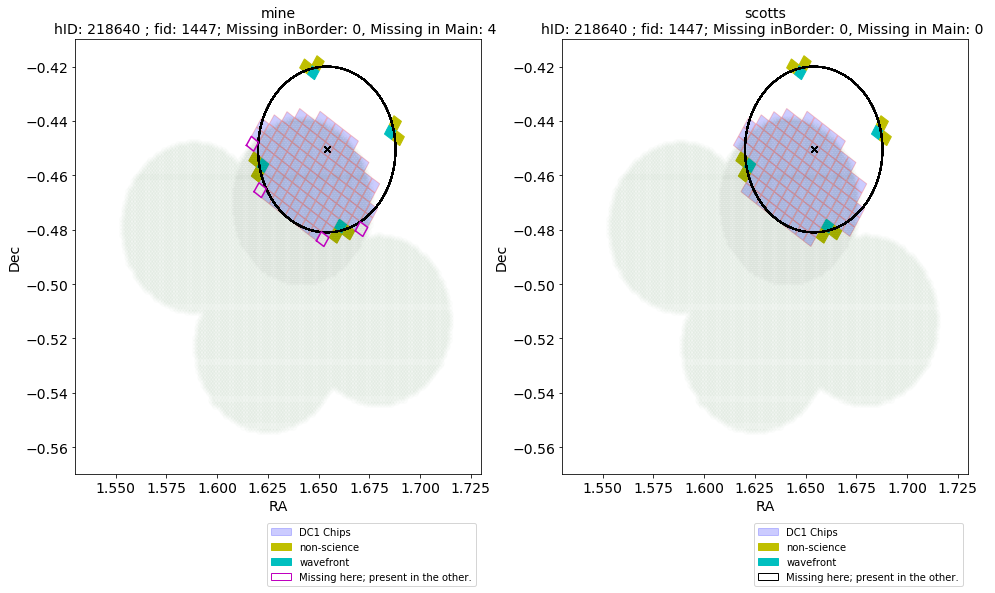

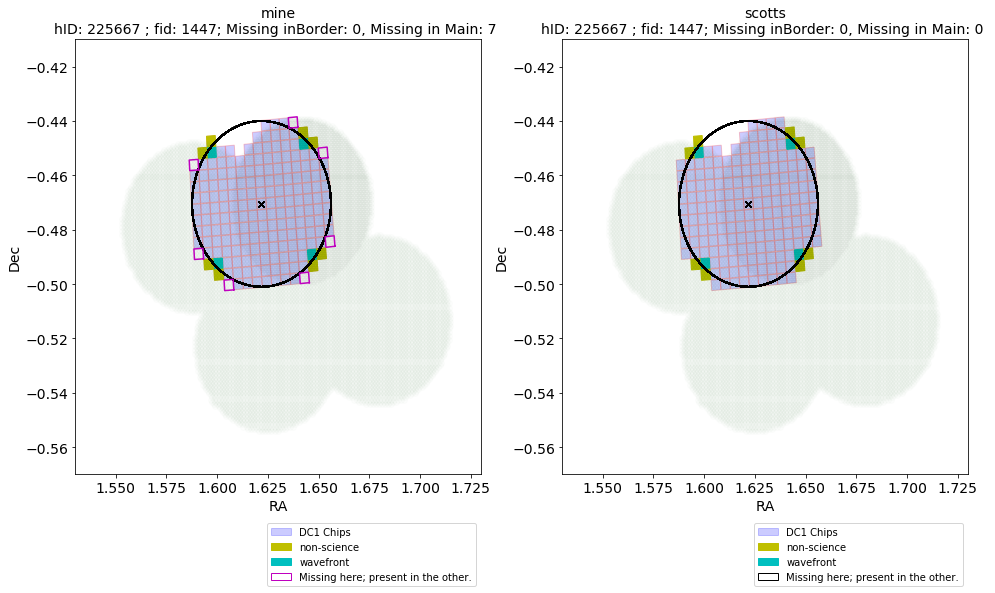

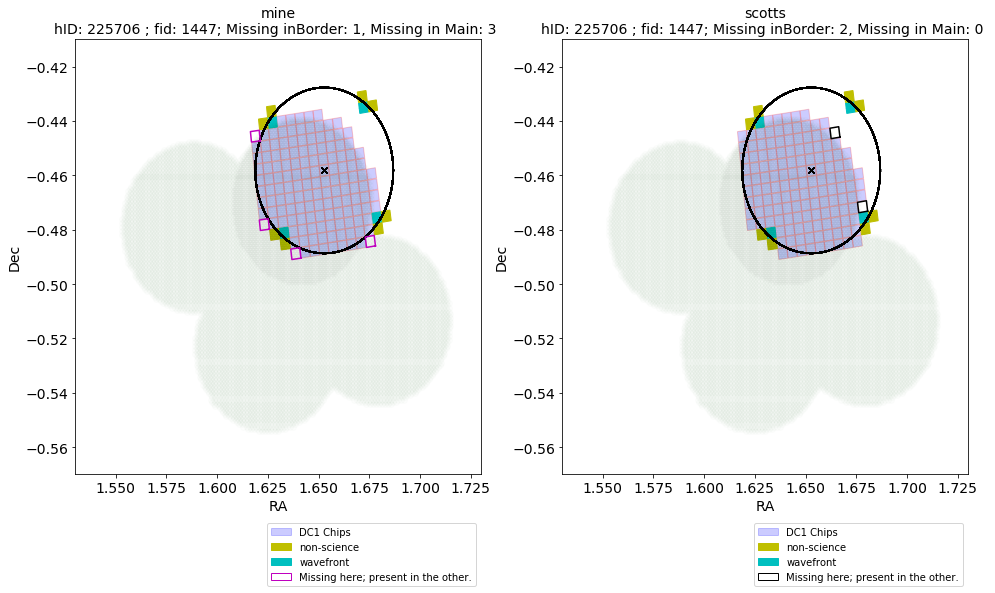

In [7]:
scotts= datapath+'/scotts_reformatted.pickle'
mine= repoDir+'/chipsPerVisitData/2017-04-06_chipPerVisitData_newAfterburnerOutput_fID1447_RandomDitherFieldPerVisit_randomRotDithered_nonDiscRegion_nside1024_192103NonWFChipsToSimulate.pickle'

nside= 1024
os.chdir(repoDir)
borderVsMainPlot(mine, scotts, nside, simdata.copy(),
                  tag= 'both%s'%nside, transDithered= True, rotDithered= True)

In [8]:
def borderVsMainMissing(filenameToRead_mine, filenameToRead_scotts, nside, simdata, tag, 
                          transDithered, rotDithered, plotInterms= False):
    # similar to function above but now no plots. just classify all the chips.
    startTime= time.time()
    
    ignore, ignore, DC1Pixels= findRegionPixels(1447, simdata, nside= nside, disc= False, FOV_radius= 0.0305)
    DC1pixRA, DC1pixDec= pixNum2RaDec(DC1Pixels, nside)

    ignore, ignore, DC1Pixels_smaller= findRegionPixels(1447, simdata, nside= nside, 
                                                        disc= False,
                                                        FOV_radius= 0.0305-(0.0305/15)) # smaller by chip side length
    DC1pixRA_smaller, DC1pixDec_smaller= pixNum2RaDec(DC1Pixels_smaller, nside)
    
    def withInBorder(xChipCenter, yChipCenter, plotInterms): 
        # check if a given pixel is in the border: 
        # it is not if it is both in the DC1 region and the smaller-DC1 region.
        
        # find whether the center is in the DC1 region
        delRA= abs(DC1pixRA-xChipCenter)
        ind= np.where(delRA<0.001)[0]
        delDec= abs(DC1pixDec[ind]-yChipCenter)
        ind= np.where(delDec<0.001)[0]
        
        if (len(ind)==0): inDC1= False
        else: inDC1= True
            
        # find whether the center is in the smaller DC1 region
        delRA= abs(DC1pixRA_smaller-xChipCenter)
        ind= np.where(delRA<0.001)[0]
        delDec= abs(DC1pixDec_smaller[ind]-yChipCenter)
        ind= np.where(delDec<0.001)[0]
        
        if (len(ind)==0):
            inDC1small= False
        else:
            inDC1small= True
        
        if not inDC1:
            withinBorder= True
        if inDC1 and inDC1small:
            withinBorder= False
        if inDC1 and not inDC1small:        
            withinBorder= True
        
        if plotInterms: # just for checks
            plt.clf()
            plt.plot(DC1pixRA, DC1pixDec,'.',)
            plt.plot(DC1pixRA_smaller, DC1pixDec_smaller, '.', )
            plt.plot(xChipCenter, yChipCenter, 'x', color='k')
            plt.title('inDC1: %s, inDC1small: %s \n Edge pixel: %s'%(inDC1, inDC1small, withinBorder))
            plt.show()
            
        return withinBorder
    
    # read in the data
    savedData= OrderedDict()
    savedData['mine']= {}
    savedData['scotts']= {}
    with open(filenameToRead_mine, 'rb') as handle:
        savedData['mine']= pickleRead(handle)

    with open(filenameToRead_scotts, 'rb') as handle:
        savedData['scotts']= pickleRead(handle)
    
    obsMetaData= {}
    for key in savedData.keys():
        obsMetaData[key]= obsMetaDataDict(savedData[key]['obsHistID'], simdata, transDithered, rotDithered)
    camera= LsstSimMapper().camera
    
    inBorder= {'mine': 0, 'scotts': 0}
    inMain= {'mine': 0, 'scotts': 0}
    totMissing= {'mine': 0, 'scotts': 0}
    
    def getChipCenter(chip, camera, obsData):
        x, y= np.zeros(4), np.zeros(4)
        [(x[0], y[0]), (x[1], y[1]), (x[3], y[3]), (x[2], y[2])]= getCornerRaDec(chip, camera, obsData)
        x, y= np.deg2rad(x), np.deg2rad(y)
        xmin= x[0]
        ymin= y[0]
        ymax= y[1]
        xmax= x[2]
        #[(xmin, ymin), (xmin, ymax), (xmax, ymin), (xmax, ymax)]=  [(x[0], y[0]), (x[1], y[1]), (x[3], y[3]), (x[2], y[2])]
        return xmin+(xmax-xmin)/2., ymin+(ymax-ymin)/2.
    
    missingData= {'mine': {}, 'scotts': {}}
    
    for fid in np.unique(savedData['mine']['fIDs']):
        missingData['mine'][fid]= []
        missingData['scotts'][fid]= []
        centralRA, centralDec, regionPixels= findFOVPixels(fid, simdata, nside= nside,
                                                           FOV_radius= 0.0305)
        key0= 'mine'
        inds= np.where(savedData[key0]['fIDs']==fid)[0]
        hID_ofInterest= np.array(savedData[key0]['obsHistID'])[inds]

        key1= 'scotts'
        inds= np.where(savedData[key1]['fIDs']==fid)[0]
        hID_ofInterest= np.array(list(hID_ofInterest) + list(np.array(savedData[key1]['obsHistID'])[inds]))  # all
        
        # run over all hids
        for hth, hid in enumerate(np.sort(np.unique(hID_ofInterest))): 
            ind_inMine= np.where(savedData['mine']['obsHistID']==hid)[0]
            ind_inScotts= np.where(savedData['scotts']['obsHistID']==hid)[0]
            
            if (len(ind_inMine)>1):
                print('PROBLEM: more than one entry for a histID.'); 
                return
            if (len(ind_inScotts)>1):
                print('PROBLEM: more than one entry for a histID.'); 
                return
            
            if ((len(ind_inMine)==0) and (len(ind_inScotts) !=0)):
                # hid only observed in scotts => all chips in scotts are missing in mine
                missingInMine= set(savedData['scotts']['chipNames'][ind_inScotts[0]]) - set(nonScience+wavefront)
                missingInScotts= []
            elif ((len(ind_inMine)!=0) and (len(ind_inScotts) ==0)):
                # hid only observed in mine => all chips in mine are missing in scotts
                missingInMine= []
                missingInScotts= set(savedData['mine']['chipNames'][ind_inMine[0]]) - set(nonScience+wavefront)
            else:
                # compare which is missing in which lsit.
                myChips= set(savedData['mine']['chipNames'][ind_inMine[0]]) - set(nonScience+wavefront)
                Scotts= set(savedData['scotts']['chipNames'][ind_inScotts[0]]) - set(nonScience+wavefront)
                missingInMine= Scotts-myChips
                missingInScotts= myChips-Scotts
            
            totMissing['mine']+= len(missingInMine)
            totMissing['scotts']+= len(missingInScotts)
            
            missingData['mine'][fid]+= missingInMine
            missingData['scotts'][fid]+= missingInScotts
            
            # set to classify the missing chips.
            if (len(ind_inMine)>0):
                meta= obsMetaData['mine'][hid]
            else:
                meta= obsMetaData['scotts'][hid]
            inborder= 0
            inmain= 0
            
            if (hth in [0, 1]) & (plotInterms): plotInterms= True
            else: plotInterms= False
            for chip in missingInMine:
                xChipCenter, yChipCenter= getChipCenter(chip, camera, meta)
                
                if withInBorder(xChipCenter, yChipCenter, plotInterms= plotInterms):
                    inborder+=1
                else:
                    inmain+=1

            inBorder['mine']+=inborder
            inMain['mine']+=inmain
            
            inborder= 0
            inmain= 0
            for chip in missingInScotts:
                xChipCenter, yChipCenter= getChipCenter(chip, camera, meta)
                if withInBorder(xChipCenter, yChipCenter, plotInterms= False):
                    inborder+=1
                else:
                    inmain+=1
            inBorder['scotts']+=inborder
            inMain['scotts']+=inmain
    return inBorder, inMain, totMissing, missingData, savedData

Exception ignored in: <bound method SqlRegistry.__del__ of <lsst.daf.persistence.registries.SqliteRegistry object at 0x15141ef28>>
Traceback (most recent call last):
  File "/Users/humnaawan/lsst/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/daf_persistence/u.danielsf.2.3.7.1.sims-g674f0d60ff/python/lsst/daf/persistence/registries.py", line 320, in __del__
    super(SqlRegistry, self).__del__()
AttributeError: 'super' object has no attribute '__del__'


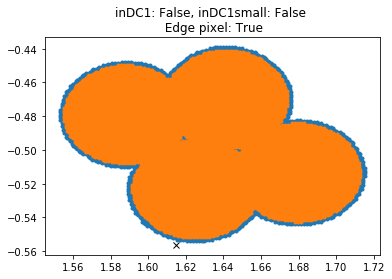

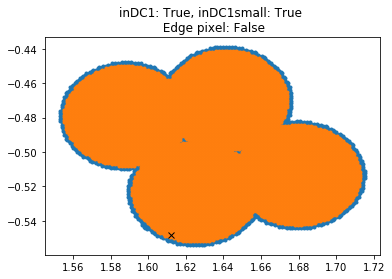

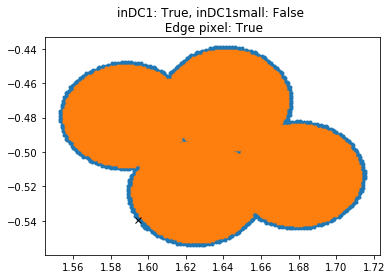

In [9]:
scotts= datapath+'/scotts_reformatted.pickle'
mine= repoDir+'/chipsPerVisitData/2017-04-06_chipPerVisitData_newAfterburnerOutput_fID1447_RandomDitherFieldPerVisit_randomRotDithered_nonDiscRegion_nside1024_192103NonWFChipsToSimulate.pickle'

nside= 1024
os.chdir(repoDir)
output= borderVsMainMissing(mine, scotts, nside, simdata.copy(),
          tag= 'both%s'%nside, transDithered= True, rotDithered= True, plotInterms= True)

In [10]:
inBorder, inMain, totMissing, missingData, savedData= output

In [11]:
pd.DataFrame({'inBorder': inBorder, 'inMain': inMain, 'totMissing': totMissing}, index= ['mine', 'scotts'])

,inBorder,inMain,totMissing
mine,2903,6900,9803
scotts,1299,70,1369


In [12]:
for key in ['mine', 'scotts']:
    print(key)
    summ= 0
    for fid in missingData[key]:
        summ+=len(missingData[key][fid])
        print('fid %s: # missing chips: %s' %(fid, len(missingData[key][fid])))

    print('\nTotal missing: %s\n'% summ)

mine
fid 1190: # missing chips: 0
fid 1212: # missing chips: 381
fid 1220: # missing chips: 577
fid 1234: # missing chips: 354
fid 1285: # missing chips: 0
fid 1293: # missing chips: 0
fid 1305: # missing chips: 720
fid 1323: # missing chips: 1231
fid 1333: # missing chips: 1193
fid 1365: # missing chips: 433
fid 1413: # missing chips: 470
fid 1431: # missing chips: 1147
fid 1447: # missing chips: 1221
fid 1464: # missing chips: 701
fid 1506: # missing chips: 0
fid 1542: # missing chips: 408
fid 1564: # missing chips: 616
fid 1568: # missing chips: 351

Total missing: 9803

scotts
fid 1190: # missing chips: 4
fid 1212: # missing chips: 67
fid 1220: # missing chips: 84
fid 1234: # missing chips: 76
fid 1285: # missing chips: 1
fid 1293: # missing chips: 3
fid 1305: # missing chips: 137
fid 1323: # missing chips: 108
fid 1333: # missing chips: 110
fid 1365: # missing chips: 102
fid 1413: # missing chips: 105
fid 1431: # missing chips: 129
fid 1447: # missing chips: 105
fid 1464: # missin

#### Ok 
So have 4 contiguous FOVs: 2 with 1/2 circumference 'open' (i.e., not surrounded by region pixels) ; the other 2 with 2/3 'open'

#### Chips missing in mine (as compared to Scotts):
inBorder: 2903	inMain: 6900

####  Lets consider if all FOVs have 1/2 OR 2/3 open (i.e. simplifying the problem by treating all FOVs similarly):

then have 2903missing/4FOV in border => 726missing in border/FOV

and have 6900missing/4FOV in main => 1725missing in main/FOV

Also, 
#### Chips missing in Scotts (as compared to mine):
inBorder: 1299	inMain: 70

####  If all FOVs are 1/2 OR 2/3 open (i.e. simplifying the problem by treating all FOVs similarly):

then have 1299missing/4FOV in border => 325missing in border/FOV

and have 70missing/4FOV in main => 18missing in main/FOV

In [13]:
# find the total number of science chips.
for key in savedData.keys():
    numChipsAll= []
    numChipsNonWF= []
    numChipToSim= []
    print(key)
    for i in range(len(savedData[key]['obsHistID'])):
        
        temp= savedData[key]['chipNames'][i]
        numChipsAll.append(len(temp))
        temp= list(set(temp)-set(wavefront))
        numChipsNonWF.append(len(temp))
        
        good= list(set(temp)-set(nonScience))
        numChipToSim.append(len(good))
    
    print('** Non-wavefront and science chips only **')
    print('-- Max number of chips added by any given visit: %d'%(max(numChipToSim)))
    print('-- Min number of chips added by any given visit: %d'%(min(numChipToSim)))
    print('-- Total number of chips (across all visits to be simulated): %d\n'%(sum(numChipToSim)))

mine
** Non-wavefront and science chips only **
-- Max number of chips added by any given visit: 183
-- Min number of chips added by any given visit: 0
-- Total number of chips (across all visits to be simulated): 184658

scotts
** Non-wavefront and science chips only **
-- Max number of chips added by any given visit: 189
-- Min number of chips added by any given visit: 0
-- Total number of chips (across all visits to be simulated): 193092



With 184658 chips:

For DC1, have 4 FOVs  => ~184658/4= 46164 pixels/FOV

=> for DC2 with 30 FOVs, expect ~1,384,920 pixels

missing in main: 1725x30/1,384,920= 3.7%